<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/345_bayesian_prediction.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayesian_prediction_notebook)=
# Predizione bayesiana e distribuzioni predittive 

L'analisi bayesiana ha diversi obiettivi, tra cui la sintesi della distribuzione a posteriori dei parametri, la verifica di ipotesi e la predizione di nuovi dati futuri. Dopo aver osservato i dati di un campione e ottenuto le distribuzioni a posteriori dei parametri, possiamo fare previsioni sulle proprietà di dati futuri. Per verificare e validare i modelli, una delle tecniche utilizzate è il *controllo predittivo a posteriori* (*Posterior Predictive Check*). Questo metodo consiste nel confrontare i dati predetti dal modello con i dati effettivamente osservati nel campione corrente. In sostanza, utilizziamo il modello corrente per fare previsioni sui possibili dati futuri e poi confrontiamo queste previsioni con i dati osservati nel campione. Se le previsioni del modello si avvicinano in modo adeguato ai dati effettivamente osservati, allora il modello è considerato valido e adatto per la descrizione dei dati.

La predizione bayesiana viene anche formulata nei termini della *distribuzione predittiva a priori*. La distribuzione predittiva a priori è la distribuzione delle osservazioni che ci aspettiamo prima di osservare qualsiasi dato. Essa si riferisce alle previsioni riguardanti le osservazioni stesse, prima che i dati siano stati raccolti. Questo è diverso dalla distribuzione a priori, che invece riguarda la distribuzione delle probabilità dei parametri prima di osservare i dati. La distribuzione predittiva a priori è utile per valutare se la scelta della distribuzione a priori sia adeguata per descrivere i dati del campione.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import seaborn as sns
from scipy.stats import betabinom, beta, binom
import pymc as pm
import xarray as xr
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## La distribuzione predittiva a posteriori

Dopo aver costruito la distribuzione a posteriori dei parametri sconosciuti attraverso l'analisi bayesiana, possiamo utilizzare questo risultato per effettuare previsioni riguardanti i possibili risultati futuri, dando origine all'analisi predittiva. Per introdurre il concetto di "distribuzione predittiva a posteriori", esamineremo qui un caso specifico, ovvero il modello beta-binomiale.

Nel contesto specifico del modello beta-binomiale, il parametro $\theta$ (probabilità di successo) ha una distribuzione a priori modellata da una distribuzione Beta, mentre la verosimiglianza è rappresentata da una distribuzione binomiale. I dati consistono nel numero $y$ di successi in $n$ prove Bernoulliane indipendenti.

Consideriamo, ad esempio, i dati relativi al campione di pazienti clinici depressi discussi da {cite:t}`zetsche_2019future`. In quel campione di 30 pazienti, abbiamo osservato che 23 di essi hanno una depressione grave. Possiamo dunque parlare di 23 "successi" in un contesto di 30 prove Bernoulliane indipendenti. Supponiamo ora di voler esaminare un altro gruppo di $m$=30 pazienti clinici in futuro e ci chiediamo quanti di essi potrebbero manifestare una depressione grave. Vogliamo fare previsioni riguardo ai risultati di nuovi possibili campioni di $m$ osservazioni.

Introduciamo la variabile casuale $\tilde{Y}$, che rappresenta il numero di pazienti con depressione grave ("successi") in un nuovo campione di $m$ pazienti clinici. Pertanto, in un nuovo campione, $\tilde{Y}$ potrebbe assumere valori come $\tilde{y}_1$ (ad esempio 12), $\tilde{y}_2$ (ad esempio 23), e così via. Il nostro obiettivo è calcolare le probabilità di osservare ciascuno dei valori di $\tilde{Y}$ compresi tra 0 e 30 inclusi. Questa distribuzione di massa di probabilità è chiamata *distribuzione predittiva a posteriori*, $p(\tilde{Y} = \tilde{y} \mid Y = y)$. Essa rappresenta la probabilità assegnata a ciascuno dei possibili valori di $\tilde{Y}$ (0, 1, 2, ..., 29, 30) nei possibili campioni futuri di $m$ pazienti clinici.

In questo capitolo, ci focalizzeremo sull'individuazione della distribuzione predittiva a posteriori nel contesto del modello beta-binomiale. Esploreremo tre diverse metodologie per raggiungere questo obiettivo:

1. **Approccio analitico**: Risolveremo la distribuzione in modo matematico.
2. **Simulazione**: Utilizzeremo la simulazione per ottenere i risultati desiderati.
3. **Campionamento MCMC**: Impiegheremo la tecnica del campionamento MCMC per stimare la distribuzione predittiva a posteriori.

Tutti e tre i metodi sono equivalenti e producono gli stessi risultati. Tuttavia, in seguito useremo il metodo MCMC, poiché ci permette di ottenere la soluzione desiderata in modo semplice, anche quando, al di là del caso beta-binomiale, non è disponibile una soluzione analitica.

### Derivazione analitica

Nel caso dell'esempio in esame, la distribuzione di $\tilde{Y}$ dipende da $\theta$ e ciò che sappiamo di $\theta$ è sintetizzato nella distribuzione a posteriori $p(\theta \mid y)$. Utilizzando la regola della catena, possiamo scrivere la distribuzione congiunta di $\tilde{y}$ e $\theta$ nel seguente modo:

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta, y) p(\theta \mid y).
$$

Assumendo che le osservazioni future $\tilde{y}$ e passate $y$ siano condizionalmente indipendenti dato $\theta$, l'espressione precedente può essere semplificata come:

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta) p(\theta \mid y).
$$

La distribuzione predittiva a posteriori viene ottenuta integrando la distribuzione congiunta di $\tilde{y}$ e $\theta$ rispetto a $\theta$:

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta.
$$ (eq-post-pred-distr)

Nel caso del modello beta-binomiale, la funzione $p(\tilde{y} \mid \theta)$ rappresenta una distribuzione binomiale con parametri $m$ e $\theta$, mentre la distribuzione a posteriori $p(\theta \mid y)$ è una distribuzione Beta con parametri $\alpha + y$ e $\beta + n - y$. Risolvendo l'integrale, otteniamo la distribuzione predittiva a posteriori:

$$
\begin{align}
p(\tilde{y} \mid y) &= \int_0^1 p(\tilde{y} \mid \theta)
p(\theta \mid y)\,\operatorname {d}\!\theta \notag\\
 &= \int_0^1 \begin{pmatrix}m\\\tilde{y}\end{pmatrix}
 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \, Beta(a+y,b+n-y) \, d\theta \notag\\
&= \begin{pmatrix}{m}\\\tilde{y}\end{pmatrix} \int_0^1 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \frac{1}{B(a+y, b+n-y)}\theta^{a+y-1}(1-\theta)^{b+n-y-1} \, d\theta \notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{1}{B(a+y, b+n-y)}\int_0^1 \theta^{\tilde{y}+a+y-1}(1-\theta)^{m-\tilde{y}+b+n-y-1} \, d\theta\notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{B(\tilde{y}+a+y,b+n-y+m-\tilde{y})}{B(a+y, b+n-y)},
\end{align}
$$ (eq-post-yprime-an-sol-betabin)

dove $B$ rappresenta la funzione beta e $\binom{m}{\tilde{y}}$ indica il coefficiente binomiale.

In conclusione, nel caso del modello beta-binomiale, la distribuzione predittiva a posteriori corrisponde a una distribuzione di probabilità discreta chiamata distribuzione beta-binomiale con parametri $m$, $\alpha + y$ e $\beta + n - y$.

$$
f(\tilde{y} \mid y) = \binom{m}{\tilde{y}} \frac{B(a+ y + \tilde{y}, b + n - y + m - \tilde{y})}{B(a+y, b+n-y)},
$$ (eq-beta-binomial-distr)

Nell'esempio relativo allo studio di {cite:t}`zetsche_2019future`, la verosimiglianza è binomiale, i dati consistono in 23 successi su 30 prove e la distribuzione a priori su $\theta$ è una Beta(2, 10). Di conseguenza, la distribuzione a posteriori è una Beta(25, 17). Il nostro obiettivo è calcolare la distribuzione predittiva a posteriori per un nuovo campione, ad esempio con $m = 30$ osservazioni (anche se in generale $m$ potrebbe essere diverso da $n$).

In base all'eq. {eq}`eq-beta-binomial-distr`, sappiamo che la distribuzione predittiva a posteriori è una distribuzione beta-binomiale con i parametri $m$ e $\alpha + y$ e $\beta + n - y$, dove $m$ rappresenta il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le proprietà del campione attuale. Nel caso dell'esempio in questione, avremo $m = 30$, $\alpha = 2 + 23 = 25$, $\beta = 10 + 30 - 23 = 17$.

Possiamo utilizzare Python per rappresentare la distribuzione predittiva a posteriori che abbiamo definito mediante la funzione `betabinom.pmf`.

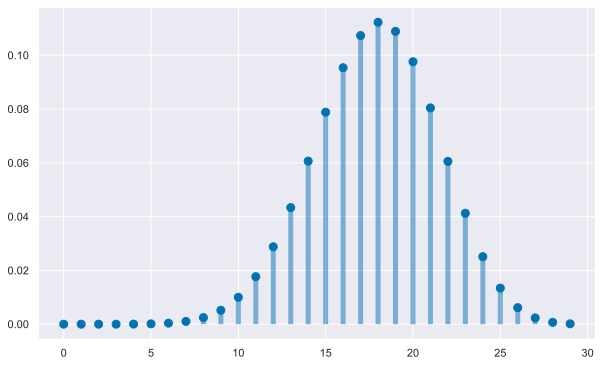

In [4]:
n = 30
a = 25
b = 17

x = np.arange(0, 30)
plt.plot(x, betabinom.pmf(x, n, a, b), "bo", ms=8, label="betabinom pmf")
_ = plt.vlines(x, 0, betabinom.pmf(x, n, a, b), colors="b", lw=5, alpha=0.5)

La distribuzione predittiva a posteriori, mostrata nella figura precedente, fornisce informazioni sulla probabilità di osservare $0, 1, \dots, 30$ successi su $m = 30$ prove in un futuro campione di osservazioni. Queste probabilità sono valutate tenendo conto dei dati osservati nel campione corrente (23 successi su 30 prove) e delle nostre opinioni iniziali sulla plausibilità dei possibili valori di $\theta$ (rappresentate dalla distribuzione a priori Beta(2, 10)). In altre parole, la distribuzione predittiva a posteriori ci offre una visione delle possibili frequenze di successo che potremmo osservare nei futuri campioni, basandoci sulle nostre conoscenze attuali e sull'esperienza passata.

Dall'analisi della distribuzione predittiva, possiamo osservare che, nei possibili campioni futuri di 30 osservazioni, il valore $\tilde{y}$ con la probabilità più alta è 18. Tuttavia, la distribuzione predittiva ci fornisce informazioni sulla probabilità relativa di ciascuno dei possibili valori futuri di $\tilde{y}$, che rappresentano il numero di pazienti clinici (su 30) che potrebbero manifestare una depressione grave. In altre parole, la distribuzione predittiva ci dà un quadro completo delle probabilità di osservare diverse quantità di pazienti con depressione grave nei futuri campioni di 30 osservazioni.

In alcuni casi, è utile costruire un intervallo che contenga le possibili realizzazioni di $\tilde{y}$ con una specifica probabilità. Supponiamo che il livello di probabilità desiderato sia 0.89. L'intervallo viene costruito aggiungendo valori di $\tilde{y}$ all'insieme (partendo da quello con la probabilità maggiore) fino a quando la probabilità accumulata supera la soglia richiesta, in questo caso 0.89. 

Nel nostro esempio, possiamo prevedere, con un alto grado di certezza soggettiva superiore al 0.91, che in un futuro campione di 30 soggetti clinici depressi, il numero di pazienti con depressione grave sarà compreso tra 12 e 23.

$$
P(12 \leq \tilde{y} \leq 23) = 0.9145.
$$

Ciò significa che vi è una probabilità del 91.45% che il numero di pazienti con depressione grave nel nuovo campione si trovi all'interno dell'intervallo tra 12 e 23.

In [4]:
x_set = np.arange(12, 24)
betabinom.pmf(x_set, n, a, b).sum()

0.9152884954868495

In conclusione, per il caso beta-binomiale, possiamo affermare che la previsione bayesiana di una nuova osservazione futura è rappresentata dalla distribuzione beta-binomiale con parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ rappresenta il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione attuale. In altre parole, la distribuzione beta-binomiale ci fornisce una stima delle possibili frequenze di successi che potremmo osservare nei futuri campioni, tenendo conto dei dati attuali e delle nostre conoscenze iniziali sulla probabilità di successo.

### Metodo basato sulla simulazione

In situazioni in cui non è possibile ottenere esattamente la distribuzione predittiva a posteriori, è comunque possibile ottenere un campione casuale di valori dalla distribuzione mediante simulazione. Nel caso in esame, supponiamo di voler generare un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. Per farlo, possiamo seguire due fasi di simulazione:

1. Estraiamo casualmente $n$ valori del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$.
2. Utilizziamo i valori del parametro $\theta$ estratti per generare $n$ valori casuali di $\tilde{y}$, utilizzando il modello binomiale con i parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$).

In questo modo, otteniamo $n$ realizzazioni casuali di $n$ distribuzioni binomiali, ciascuna con i parametri specificati sopra, le quali rappresentano un campione casuale di valori della distribuzione predittiva a posteriori.

Vediamo come ottenere questo risultato in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori di $\theta$ è una Beta(25, 17). Procediamo con l'estrazione casuale di 100,000 valori da questa distribuzione e stampiamo i primi 10 di essi:

In [5]:
nrep = 100000
theta = beta.rvs(a, b, size=nrep)
print(*theta[0:10])

0.6301143507725697 0.6413713579204026 0.583775205608884 0.6027863812202187 0.5949233511491817 0.6333188023380555 0.5390541888093853 0.7077440554808354 0.44371318659990855 0.5322866586188878


Per ciascuno dei 100,000 valori estratti per $\theta$, generiamo casualmente un valore dalla distribuzione binomiale con parametri $n = 30$ e probabilità $\theta$. Osserviamo i primi 10 valori così ottenuti.

In [6]:
pred_y_sim = [binom.rvs(n=30, p=th, size=1) for th in theta]
pred_y_sim = np.concatenate(pred_y_sim)
print(*pred_y_sim[0:10])

16 21 15 14 21 19 11 24 11 15


L'insieme dei valori `pred_y_sim` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Nell'illustrazione sottostante, è presente un istogramma che mostra la distribuzione dei valori `pred_y_sim`. I punti corrispondenti alla distribuzione a posteriori corretta, ossia una distribuzione Beta-Binomiale con parametri $n = 30$, $a = 25$, e $b = 17$, sono sovrapposti sull'istogramma. Si può notare una notevole concordanza tra i valori ottenuti tramite la simulazione e quelli previsti attraverso una derivazione analitica.

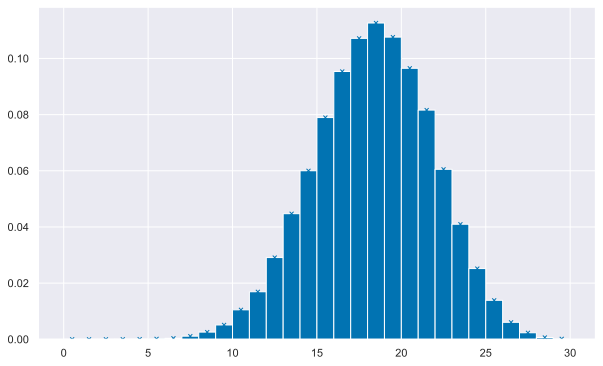

In [11]:
counts, bins, _ = plt.hist(pred_y_sim, bins=np.arange(0, 31), density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
_ = plt.plot(bin_centers, counts, "bx", ms=4)

### Metodo MCMC

Il metodo di simulazione discusso sopra segue la stessa logica utilizzata dai metodi MCMC per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, vengono stimate le possibili osservazioni future $p(\tilde{y} \mid y)$, rappresentate come $p(y^{rep} \mid y)$, attraverso i seguenti passaggi:

1. Campionare $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro dalla distribuzione a posteriori.
2. Campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene selezionata casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. In alcuni casi, come nel presente esempio, è possibile ottenere analiticamente la distribuzione predittiva a posteriori. In altre situazioni, invece, l'utilizzo dei metodi MCMC consente di ottenere un'approssimazione accurata della distribuzione predittiva a posteriori quando una derivazione analitica non è possibile.

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con PyMC per i dati dell'esempio. Iniziamo a creare la distribuzione a posteiori di $\theta$.

In [12]:
ntrials = 30
y = 23

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


Una rappresentazione grafica della distribuzione a posteriori è fornita nella figura seguente.

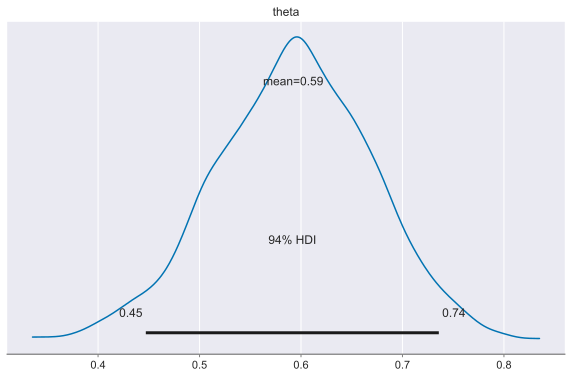

In [13]:
_ = az.plot_posterior(idata.posterior.theta)

Generiamo ora un campione di osservazioni estratto dalla distribuzione predittiva a posteriori, $y^{rep} \sim p(y^{rep} \mid \theta_i)$.

In [14]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Esaminiamo i dati ottenuti.

In [15]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 2000)>
array([[17, 21, 13, ..., 13, 21, 19],
       [ 8, 11, 20, ..., 21, 17, 22],
       [19, 18, 20, ..., 27, 23, 17],
       [15, 15, 17, ..., 25, 18, 11]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

Creiamo un istogramma con i dati $y^{rep}$. Si noti che il risultato riproduce ciò che abbiamo ottenuto in precedenza per via analitica e tramite simulazione. L'intervallo di credibilità del 91% è, anche in questo caso, pari a [12, 23].

<Axes: title={'center': 'obs'}>

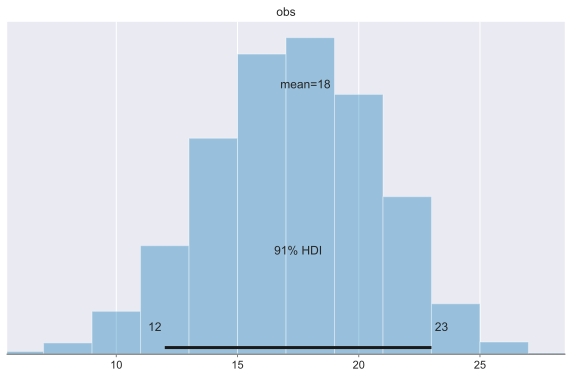

In [16]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.91)

### Posterior predictive checks

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

## Distribuzione predittiva a priori

Nella sezione precedente abbiamo esaminato come la distribuzione predittiva venga utilizzata per generare previsioni sui dati futuri. In particolare, l'equazione {eq}`eq-post-pred-distr` descrive la nostra incertezza riguardo alla distribuzione delle future osservazioni di dati, tenendo conto della distribuzione a posteriori di $\theta$ e della scelta del modello basata sui dati osservati. 

Una seconda forma in cui si manifesta la predizione bayesiana è quella della *distribuzione predittiva a priori*, che descrive la distribuzione dei dati futuri previsti dal modello prima di aver osservato il campione $y$. Se i dati osservati $y$ non sono coerenti con la distribuzione predittiva a priori, ciò implica che il modello bayesiano (cioè, la scelta della distribuzione a priori, la scelta del meccanismo generatore dei dati o entrambi) non è specificato correttamente. In altre parole, questo suggerisce che, secondo il modello bayesiano formulato, è improbabile che si verifichino i dati che sono stati effettivamente osservati. Questo indica chiaramente che il modello è inadeguato.

La distribuzione predittiva a priori può essere facilmente ottenuta se l'inferenza è svolta mediante i metodi MCMC. Per ottenere la distribuzione predittiva a priori, si replica la procedura usata per la generazione della distribuzione predittiva a posteriori, ma senza includere alcuna informazione relativa ai dati osservati. In altre parole, si utilizza la distribuzione a priori senza considerare i dati osservati, fornendo una stima della distribuzione dei dati futuri previsti dal modello prima di osservare il campione attuale.

Se ritorniamo all'esempio con i dati di {cite:t}`zetsche_2019future`, è importante ricordare che abbiamo scelto una distribuzione Beta(2, 10) come distribuzione a priori. Tuttavia, eseguendo l'analisi predittiva a priori, ci rendiamo facilmente conto che questa scelta di distribuzione (Beta(2, 10)) non è adeguata per i dati considerati. 

In [8]:
ntrials = 30
y = 23

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [obs, theta]


In [18]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Possiamo usare `arviz` per generare un istogramma della distribuzione predittiva a priori:

<Axes: title={'center': 'obs'}>

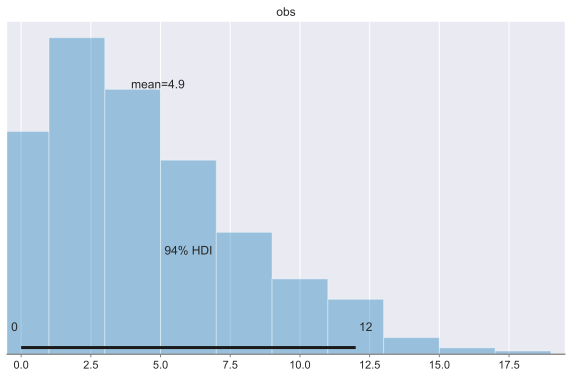

In [9]:
az.plot_posterior(idata.prior_predictive.obs)

La regione HDI al 94% è [0, 12], tuttavia abbiamo osservato $y$ = 23. Questo risultato indica chiaramente che la distribuzione Beta(2, 10) non è adeguata come distribuzione a priori per i nostri dati.

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pymc      : 5.3.0
numpy     : 1.23.5
seaborn   : 0.12.2
scipy     : 1.10.1
xarray    : 2023.4.2
matplotlib: 3.7.1
pandas    : 1.5.3
arviz     : 0.15.1

Watermark: 2.3.1

